    # Face Validity

## 1. Noisy Hopfiled  Networks reproduce dynamics of th resting state

## 2. Task-activity maps differently to the Hopfield embeddings than rest
    - energy
    - attractor
    - location/trajectory

## 3. Hopfield-embeddings explain taks-activations better than resting state by itself


In [290]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
from glob import glob
from nilearn import plotting
from sklearn.preprocessing import StandardScaler
from connattractor import network, analysis
from scipy import interpolate
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile).iloc[:, 1:]
mtx

,CER6_p,CER7ab,R_CERCR2_p,CER9_v,CER6_a,L_CERCR2_a,CER9_d,CER9_m,CER7b_m,L_CERCR2_p,...,LVISnet_vp,MVISnet_p,MVISnet_av,LVISnet_p,PVISnet_dm,PVISnet_vm,MVISnet_ad,VVISnet_l,LVISnet_DP,VVISnet_m
0,1.000000,0.023502,0.136701,0.008193,0.074264,0.021580,0.170827,0.028969,0.015883,0.130981,...,-0.002248,-0.008683,0.000152,0.035482,0.007705,-0.029055,0.009439,-0.001390,0.009582,0.007318
1,0.023502,1.000000,0.008167,0.024126,0.046648,0.050263,0.010915,0.070042,0.085829,-0.018248,...,0.033791,0.004000,0.011493,0.007582,-0.026080,0.008013,-0.009007,0.009144,0.001391,0.012831
2,0.136701,0.008167,1.000000,0.005056,0.062669,0.028488,0.041643,0.045169,0.112164,0.157129,...,-0.003300,0.016258,-0.011801,-0.001794,-0.000603,0.012350,-0.002757,-0.004949,-0.004858,-0.000633
3,0.008193,0.024126,0.005056,1.000000,-0.020494,-0.008721,-0.004522,0.203525,-0.003757,0.019182,...,0.021645,0.000472,-0.003774,0.003395,-0.032710,-0.015305,0.007360,0.004044,-0.011696,-0.001293
4,0.074264,0.046648,0.062669,-0.020494,1.000000,0.080293,0.024584,0.002491,-0.021720,0.042291,...,-0.020753,0.005295,-0.012844,-0.014833,0.009989,0.024167,-0.005186,-0.016061,0.010920,-0.007650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.029055,0.008013,0.012350,-0.015305,0.024167,-0.007512,0.045950,0.010056,-0.006412,-0.000421,...,0.011186,0.215436,-0.011083,-0.003814,0.163692,1.000000,0.013773,0.049101,-0.028493,0.115196
118,0.009439,-0.009007,-0.002757,0.007360,-0.005186,-0.023476,-0.004195,-0.029927,-0.023948,-0.023841,...,-0.012657,0.258308,0.091981,0.007686,-0.001867,0.013773,1.000000,-0.013407,0.017465,0.032366
119,-0.001390,0.009144,-0.004949,0.004044,-0.016061,0.004057,0.002311,-0.022643,0.001888,-0.007811,...,0.139682,-0.014010,0.077810,0.079338,0.055300,0.049101,-0.013407,1.000000,0.081084,0.162297
120,0.009582,0.001391,-0.004858,-0.011696,0.010920,0.002928,-0.001322,0.004114,-0.006720,-0.008002,...,0.066451,0.001324,-0.001214,0.115287,0.089609,-0.028493,0.017465,0.081084,1.000000,0.000165


## Hopfield embeddings and resting state data
First look at the speed of state transitions, it's adjustable with the noise_coef in the simulations

## let's look at the ditribution of the data on the 2D Hopfiled-projection

In [4]:
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


In [1343]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.37]:
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=2023)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults_all[noise], 
                                                                attractor_sample=1000,random_state=2023)

100%|██████████| 1000/1000 [00:59<00:00, 16.73it/s]


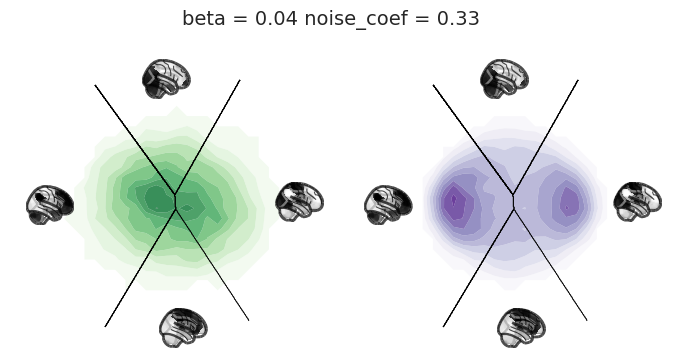

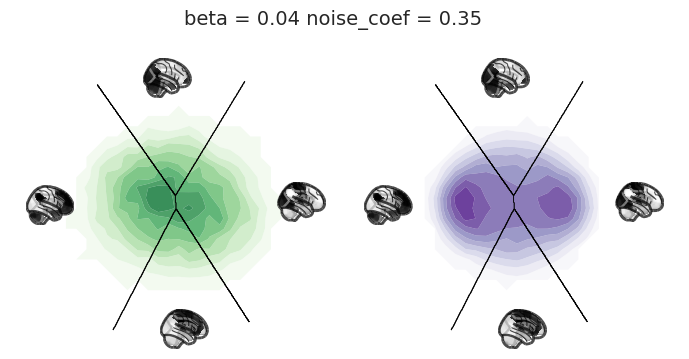

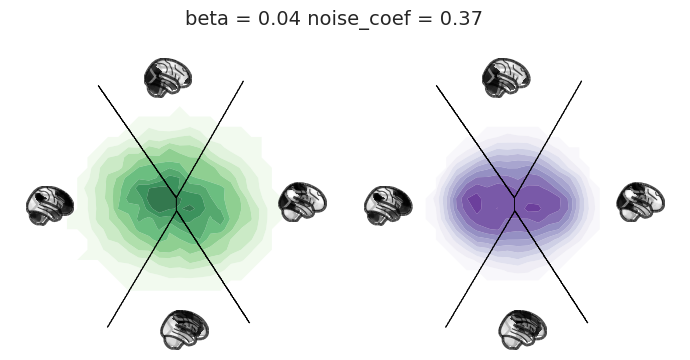

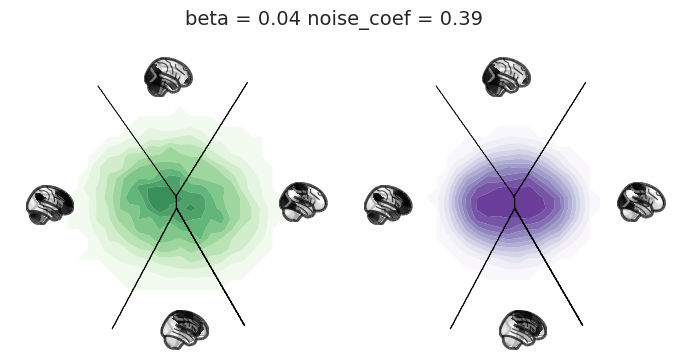

In [7]:
for i in simresults_all.keys():

    fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(8, 4))
    fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
    hopfield_embeddings_all[i].plot(all_ts, plot_type='contourf', ax=ax[0],
                             density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Greens',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[0].set_yticks([])
    ax[0].grid(False)

    hopfield_embeddings_all[i].plot(simresults_all[i].states, plot_type='contourf', ax=ax[1],
                             density_bins=30, density_sigma=0, levels=12, alpha=0.8, cmap='Purples',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[1].set_yticks([])
    ax[1].grid(False)
    plt.savefig('../data_out/fig/emp_vs_generated_beta_' + str(i) + '.pdf')
    plt.show()


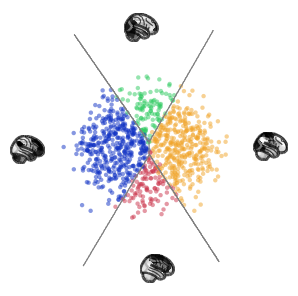

In [45]:
noise = 0.37
colors = np.array(['#cb334a', '#0f31c4', '#f1a429', '#2ecb61'])
fig, ax = plt.subplots(figsize=(3.5,3.5), subplot_kw={'projection': 'polar'})
ax=hopfield_embeddings_all[noise].plot(
                        hopfield_embeddings_all[noise].state_sample,
                        s=10, ax=ax, linewidth=0,
                        c=colors[hopfield_embeddings_all[noise].attractor_sample.astype(int)], 
                        alpha=0.5, regimes_fill_kwargs=dict(alpha=0),
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary')
)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/embedding_example.pdf')

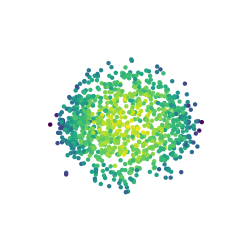

In [182]:
noise = 0.33
colors = np.array(['#2ecb61', '#0f31c4','#f1a429', '#cb334a'])

energy = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in hopfield_embeddings_all[noise].state_sample])

fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': 'polar'})
ax=hopfield_embeddings_all[noise].plot(
                        hopfield_embeddings_all[noise].state_sample,
                        s=10, ax=ax,
                        c=energy,
                        cmap='viridis',
                        alpha=1, regimes_fill_kwargs=dict(alpha=0),
                        regimes_contour_kwargs=dict(alpha=0),
                        attractor_kwargs=dict(alpha=0),
                        attractor_plot_type='scatter'#, attractor_kwargs=dict(cmap='binary')
)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/embedding_energy.pdf')

(array([  3.,   5.,  17.,  31.,  75., 140., 227., 261., 181.,  60.]),
 array([-264.37798932, -236.63577764, -208.89356597, -181.15135429,
        -153.40914261, -125.66693093,  -97.92471926,  -70.18250758,
         -42.4402959 ,  -14.69808422,   13.04412745]),
 <BarContainer object of 10 artists>)

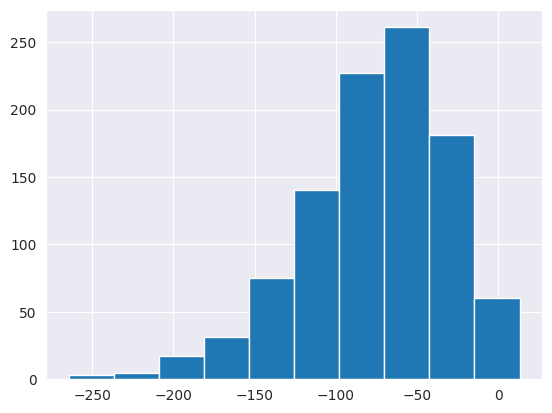

In [184]:
plt.hist(energy)

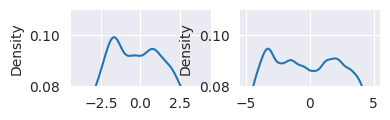

In [227]:
noise = 0.37
density_bins=25

fig, ax = plt.subplots(ncols=2, figsize=(4, 1), sharey=False, sharex=False)

states = StandardScaler().fit_transform(np.array(all_ts).T).T
embeddings = hopfield_embeddings_all[noise].embedding_model.transform(states)

max_r = np.max(np.abs(embeddings))
H, x_edges, y_edges = np.histogram2d(embeddings[:, 1], embeddings[:, 0],
                                                     bins=density_bins,
                                                     density=True,
                                                     range=[[-max_r*1.2, max_r*1.2], [-max_r*1.2, max_r*1.2]])


df = pd.DataFrame({
    'x': (x_edges[1:]+x_edges[:-1])/2,
    'y': H[int(np.round(density_bins/2)),:]
})
sns.kdeplot(embeddings[np.abs(embeddings[:,1])<=1.5, 0].flatten(), bw_adjust=0.6, ax=ax[0])
ax[0].set_xlim(-4.5,4.5)
ax[0].set_ylim(0.08,0.11)
#ax[0].spines['right'].set_visible(False)
#ax[0].spines['top'].set_visible(False)


states = StandardScaler().fit_transform(np.array(simresults_all[noise].states).T).T
embeddings = hopfield_embeddings_all[noise].embedding_model.transform(states)

max_r = np.max(np.abs(embeddings))
H, x_edges, y_edges = np.histogram2d(embeddings[:, 1], embeddings[:, 0],
                                                     bins=density_bins,
                                                     density=True,
                                                     range=[[-max_r*1.2, max_r*1.2], [-max_r*1.2, max_r*1.2]])

df = pd.DataFrame({
    'x': (x_edges[1:]+x_edges[:-1])/2,
    'y': H[int(np.round(density_bins/2)),:]
})
sns.kdeplot(embeddings[np.abs(embeddings[:,1])<=1.5, 0].flatten(), bw_adjust=0.8, ax=ax[1])
ax[1].set_xlim(-5.5,5.5)
ax[1].set_ylim(0.08,0.11)
#ax[1].spines['right'].set_visible(False)
#ax[1].spines['top'].set_visible(False)
plt.savefig('../data_out/fig/connectome_empirical_peak.pdf')



In [1502]:
def add_relative_streamplot(projection1, projection2,
                             stream_bins=30, ax=None, max_r=None, **kwargs):
    from scipy.stats import binned_statistic_2d
    
    if ax is None:
        ax = plt.gca()
    if max_r is None:
        max_r = np.max(np.abs(np.vstack((projection1, projection2))))
    
    default_kwargs = dict(linewidth=5, density=1.2)
    default_kwargs.update(kwargs)
    stream_linewidth = default_kwargs.pop('linewidth')
    
    directions1 = projection1[1:, :] - projection1[:-1, :]

    dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
                                                    np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)])

    directions2 = projection2[1:, :] - projection2[:-1, :]

    dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
                                                    np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)])
    
    density, x_edges, y_edges = np.histogram2d(projection2[:-1, 1], projection2[:-1, 0],
                                                     bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)],
                                                     density=True,
                                                     )

    x, y = np.meshgrid(x_edges[:-1],
                       y_edges[:-1])

    dir_x = dir_x_2-dir_x_1
    dir_y = dir_y_2-dir_y_1

    speed = np.sqrt(dir_x ** 2 + dir_y ** 2)

    ax_cart = ax.figure.add_axes(ax.get_position(), polar=False, frameon=False, zorder=-1)
    ax_cart.streamplot(x, y, dir_x, dir_y,
                        #linewidth= stream_linewidth * speed / speed[~ np.isnan(speed)].max(),
                       color = density,
                      **default_kwargs)
    return ax_cart, dir_x, dir_y

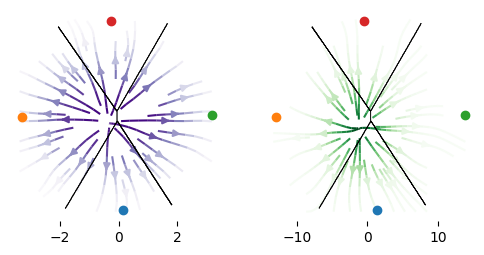

In [1503]:
noise=0.37

random = np.random.default_rng(2023)
perm  = random.permutation(np.arange(all_ts.shape[0]))

embedded_sim = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states)
embedded_sim_perm = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states[perm, :])

embedded_emp = hopfield_embeddings_all[noise].embedding_model.transform(all_ts)
embedded_emp_perm = hopfield_embeddings_all[noise].embedding_model.transform(all_ts[perm, :])


fig, ax = plt.subplots(ncols = 2, subplot_kw={'projection': 'polar'}, figsize=(6, 3))

hopfield_embeddings_all[noise].plot(simresults_all[noise].states, plot_type='contourf', ax=ax[0],
                    density_bins=50, density_sigma=0, levels=12, alpha=0, cmap='Purples',
                    attractor_plot_type='scatter',# attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_sim_perm, embedded_sim, ax=ax[0],
                                  stream_bins = 20, density=1, linewidth=5, cmap='Purples')

ax[0].set_yticks([])
ax[0].grid(False)
ax_cart.set_yticks([])
ax_cart.grid(False)

hopfield_embeddings_all[noise].plot(all_ts, plot_type='contourf', ax=ax[1],
                    density_bins=50, density_sigma=0.5, levels=12, alpha=0, cmap='Greens',
                    attractor_plot_type='scatter',# attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_emp_perm, embedded_emp, ax=ax[1],
                                 stream_bins = 20, density=2, linewidth=5, cmap='Greens')

ax[1].set_yticks([])
ax[1].grid(False)
ax_cart.set_yticks([])
ax_cart.grid(False)


## Reconstructing step size

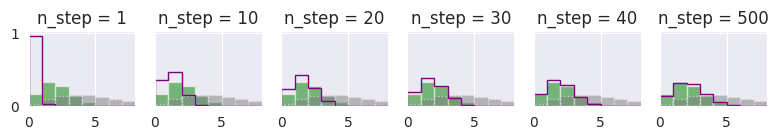

In [190]:
noise = 0.37

# load data
from glob import glob
import os

fig, ax = plt.subplots(ncols=6, figsize=(8, 1.5), sharey=True, sharex=True)

random = np.random.default_rng(2023)

all_ts = []
root_dir = '../data_in/ex_timeseries/'

norms_emp = []
norms_emp_perm = []
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(ts)
    
    perm  = random.permutation(np.arange(ts.shape[0]))
    embedded_perm = hopfield_embeddings_all[noise].embedding_model.transform(ts[perm, :])
    
    # no scrubbing to preserve continuity
    deltas = embedded[1:, :] - embedded[:-1, :]
    norms_emp.append(np.sqrt(deltas[:,0]**2 + deltas[:,1]**2))
    
    deltas_perm = embedded_perm[1:, :] - embedded_perm[:-1, :]
    norms_emp_perm.append(np.sqrt(deltas_perm[:,0]**2 + deltas_perm[:,1]**2))

from matplotlib import cm
maxstep=20
for i, step in enumerate([1, 10, 20, 30, 40, 500]):
    # calculate norms
    activations = StandardScaler().fit_transform(simresults_all[noise].states.T).T
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states)
    deltas = embedded[step:, :] - embedded[:-step, :]
    norms_sim = np.sqrt(deltas[:,0]**2 + deltas[:,1]**2)
    
    ax[i].hist(np.array(norms_emp).flatten(), bins=12, histtype='bar', range=(0,12),
         alpha=0.5, density=True, color='green')
    ax[i].hist(np.array(norms_emp_perm).flatten(), bins=12, histtype='bar', range=(0,12),
         alpha=0.5, density=True, color='gray', linestyle=':')
    ax[i].set(title='n_step = ' + str(step))
    
    ax[i].hist(norms_sim, bins=12, histtype='step', range=(0,12),
             density=True, color="purple")
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
plt.gca().set_xlim((0, 8))
plt.tight_layout()
plt.savefig('../data_out/fig/step_convergence.pdf')


## Reconstruction of the connectome

In [191]:
from nilearn import plotting

def plot_matrix(mat, **kwargs):
    
    mat[range(mat.shape[0]), range(mat.shape[0])] = 0
    
    atlas_labels = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t')
    
    labels = atlas_labels.labels.values
    modules = atlas_labels.modules.values
    
    fig = plt.gcf()
    fig.set_size_inches(3, 3)
    ax = fig.add_axes([0,0,1,1], frameon=False)
    
    plotting.plot_matrix(mat, **kwargs, zorder=0, axes=ax)
    
    prev=""
    idx=0
    
    
    for i in range(len(labels)):
        if modules[i]!=prev:
            print(modules[i])
            ax.plot([-5, len(labels) + 0.5], [i-0.5, i-0.5], linewidth=1, color='gray', zorder=100)
            ax.plot([i - 0.5, i - 0.5], [-5, len(labels) + 0.5], linewidth=1, color='gray', zorder=100)

            idx=idx+1
            prev=modules[i]

/home/tspisak/src/connattractor/venv/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


CER
DMnet
FPnet_VISDN
LIMnet
MOTnet
VATTnet_SALnet_BG_THAL
VISnet


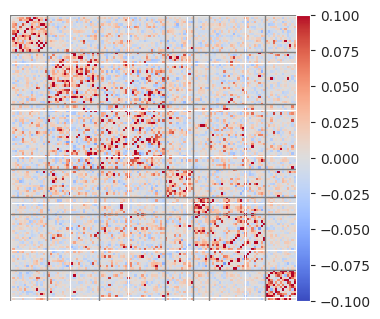

In [192]:
from nilearn.connectome import ConnectivityMeasure

plot_matrix(mtx.values, vmin=-0.1, vmax=0.1, cmap="coolwarm", tri='full')
plt.savefig('../data_out/fig/connectome_empirical.pdf')

100%|██████████| 7200/7200 [00:02<00:00, 2564.33it/s]
/home/tspisak/src/connattractor/venv/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


CER
DMnet
FPnet_VISDN
LIMnet
MOTnet
VATTnet_SALnet_BG_THAL
VISnet


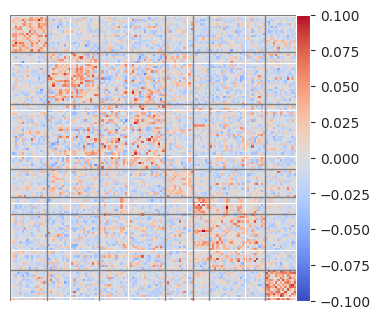

In [193]:
noise=0.37
sim = analysis.simulate_activations(mtx.values, noise_coef=noise, num_iter=7200, beta=0.04)
correlation_measure = ConnectivityMeasure(kind="partial correlation")
reconstructed_matrix = correlation_measure.fit_transform([sim.states])[0]
plot_matrix(reconstructed_matrix, vmin=-0.1, vmax=0.1, cmap="coolwarm", tri='full')
plt.savefig('../data_out/fig/connectome_reconstructed.pdf')

In [311]:
# PCA explained var
noise = 0.37

import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

from sklearn.decomposition import PCA

pca_raw_study1 = PCA().fit(all_ts)
pca_hopfield_study1 = PCA().fit(simresults_all[noise].states)

perc. scrubbed: 0.515


In [312]:
#point estimates
reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_raw_pca = np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2
reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_hop_pca = np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2

# bootstrap
n_boot=100
r2_raw_pca_boot = []
r2_hop_pca_boot = []
for i in tqdm(range(n_boot)):
    
    bootstrap_idx = random.choice(all_ts.shape[0], size=all_ts.shape[0], replace=True)
    
    reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_raw_pca_boot.append(np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

    reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_hop_pca_boot.append(np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

r2_raw_pca, np.quantile(r2_raw_pca_boot, (0.05, 0.95)), r2_hop_pca, np.quantile(r2_hop_pca_boot, (0.05, 0.95))

100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


(0.37012332060477515,
 array([0.36453183, 0.37621813]),
 0.39903741367193896,
 array([0.39342545, 0.40496875]))

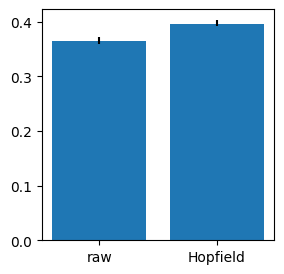

In [301]:
means = [r2_raw_pca, r2_hop_pca]
labels = ['raw', 'Hopfield']
conf = np.array([np.quantile(r2_raw_pca_boot, (0.005, 0.995)),
              np.quantile(r2_hop_pca_boot, (0.005, 0.995))])

yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T                  
             
fig, ax = plt.subplots(figsize=(3, 3))
plt.bar(labels, means, align='center', 
        yerr=yerr)
plt.savefig('../data_out/fig/pca_in-sample.pdf')

In [296]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('essen-*.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

n_comp=2

random = np.random.default_rng(42)

#point estimates
reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_raw_pca = np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2
reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_hop_pca = np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2

# bootstrap
n_boot=100
r2_raw_pca_boot = []
r2_hop_pca_boot = []
for i in tqdm(range(n_boot)):
    
    bootstrap_idx = random.choice(all_ts.shape[0], size=all_ts.shape[0], replace=True)
    
    reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_raw_pca_boot.append(np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

    reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_hop_pca_boot.append(np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

r2_raw_pca, np.quantile(r2_raw_pca_boot, (0.05, 0.95)), r2_hop_pca, np.quantile(r2_hop_pca_boot, (0.05, 0.95))

perc. scrubbed: 0.503448275862069
perc. scrubbed: 0.5103448275862069


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


(0.36420558035450123,
 array([0.36062867, 0.36767508]),
 0.3960614665514012,
 array([0.39254348, 0.39938508]))

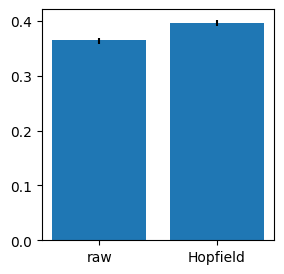

In [299]:
means = [r2_raw_pca, r2_hop_pca]
labels = ['raw', 'Hopfield']
conf = np.array([np.quantile(r2_raw_pca_boot, (0.005, 0.995)),
              np.quantile(r2_hop_pca_boot, (0.005, 0.995))])

yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T                  
             
fig, ax = plt.subplots(figsize=(3, 3))
plt.bar(labels, means, align='center', 
        yerr=yerr)
plt.savefig('../data_out/fig/pca_out-of-sample.pdf')

# Hopfiled embedding of task-based timeseries
- energy
- attractor
- embedding of task vs. rest

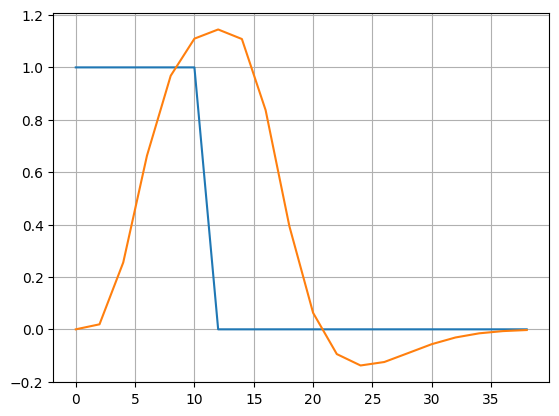

In [1357]:
from nilearn.glm.first_level import compute_regressor
signal, _labels = compute_regressor(
    exp_condition = np.array((0, 12, 1)).reshape(3, 1),
    hrf_model = 'spm',
    frame_times = np.arange(0,40, step=2))

plt.plot(np.arange(0,40, step=2), [1]*6 + [0]*14)
plt.plot(np.arange(0,40, step=2), signal)
plt.grid(True)

In [1358]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts.txt', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-01_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    for i in events.index: 
        
        onset = int(np.round(events.loc[i, "onset"]/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]
        #else:
        #    # anticipation and scoring
        #    current_block = ts[(onset+int(np.round((0)/_TR_))):(onset+int(np.round(6/_TR_))), :]
        #    rest = np.vstack((rest, current_block))                
   
# remove all nans (scrubbing)

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)
                                                              

perc. scrubbed: 0.8133971291866029
perc. scrubbed: 0.5741626794258373
perc. scrubbed: 0.6267942583732058
perc. scrubbed: 0.7081339712918661


((405, 122), (1052, 122), array([42.3, 43.3, 44.3, 45.3, 46. , 46.3]), 405)

In [1359]:
# save for later:
rest_noreg = rest.copy()
task_noreg = task.copy()
sub_rest_noreg = sub_rest.copy()
sub_task_noreg = sub_task.copy()

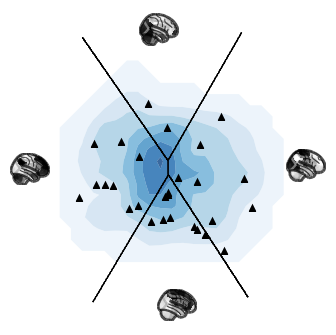

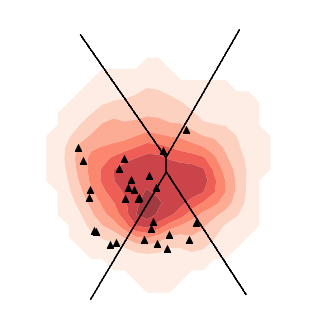

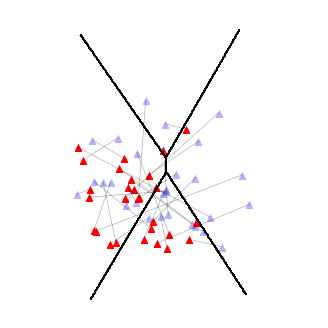

In [1361]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_rest.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_pain.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


for i in range(len(sub_means)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    


ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_pain-rest.pdf')

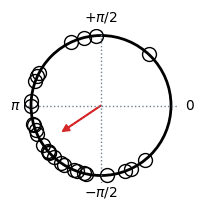

In [1362]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_rest = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
emb_sub_means_task = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
diffs = emb_sub_means_task - emb_sub_means_rest
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

fig, ax = plt.subplots(figsize=(2, 2))

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'), ax=ax)
plt.savefig('../data_out/fig/pain_circplot.pdf')

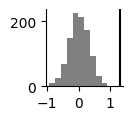

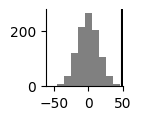

p(projection) = 0.0 p(energy) = 0.0


In [1381]:
from numpy.linalg import norm
random = np.random.default_rng(42)
noise = 0.37
num_perm = 1000


sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

task_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
rest_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
diffs = task_embedded - rest_embedded
true_diffs_norm = np.array([norm(d) for d in diffs])
true_diff_mean = np.mean(diffs_norm)

energy_rest = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_rest])
energy_task = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_task])
true_energy_diff = energy_rest - energy_task
true_energy_diff_mean = np.mean(true_energy_diff)

n = len(diffs)
diffs = []
energy_diffs = []

for p in range(num_perm):
    
    
    # swap conditions randomly (i.e. sign flip)
    
    perm_i = random.choice([1,-1], n)
    diffs.append(np.mean(true_diffs_norm * perm_i))
    energy_diffs.append(np.mean(true_energy_diff * perm_i))
    
    
    
    task_perm = all_data[perm_i, :][:task_n, :]
    rest_perm = all_data[perm_i, :][task_n:(task_n+rest_n), :]                                                 

plt.figure(figsize=(1,1))
plt.hist(diffs, color='gray')
plt.axvline(true_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_task_vs_rest.pdf')
plt.show()

plt.figure(figsize=(1,1))
plt.hist(energy_diffs, color='gray')
plt.axvline(true_energy_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_task_vs_rest_energy.pdf')
plt.show()


print('p(projection) =', (diffs>true_diff_mean).sum()/num_perm,
      'p(energy) =', (energy_diffs>true_energy_diff_mean).sum()/num_perm)
    

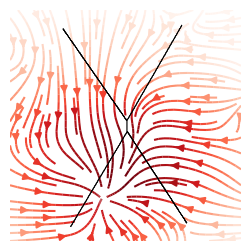

In [1764]:
embedded_rest = hopfield_embeddings_all[noise].embedding_model.transform(rest_noreg)
embedded_pain = hopfield_embeddings_all[noise].embedding_model.transform(task_noreg)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 3))

hopfield_embeddings_all[noise].plot(task_noreg, plot_type='contourf', ax=ax,
                    density_bins=10, density_sigma=0, levels=12, alpha=0, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_rest, embedded_pain, ax=ax, max_r=4,
                                  stream_bins = 6, density=1, linewidth=6, cmap='Reds')

dirs_pain_vs_rest_empirical = np.vstack((dir_x, dir_y))

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_pain_vs_rest.pdf')


100%|██████████| 50000/50000 [00:25<00:00, 1935.56it/s]


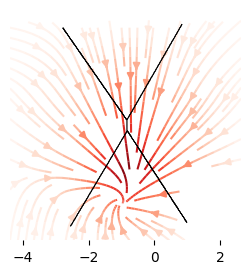

In [1765]:
#pain_map = network.State('../data_in/maps/placebo_metaanalysis_full_pain_g_random.nii.gz')

simresults_rest = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                      num_iter=50000, beta=0.04,
                                                      random_state=42)

SNR = 0.08
signal = np.array(pain_map)
#signal[np.argwhere(mtx.colums.values == "CAUDNH_NACC").squeeze()] = 1

simresults_pain = analysis.simulate_activations(mtx.values, noise_coef=0.5, 
                                                      num_iter=50000, beta=0.04,
                                                      signal = signal * SNR,
                                                      random_state=43)

embedded_rest = hopfield_embeddings_all[noise].embedding_model.transform(simresults_rest.states)
embedded_pain = hopfield_embeddings_all[noise].embedding_model.transform(simresults_pain.states)

np.max(np.abs(np.vstack((embedded_rest, embedded_pain))))


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 3))

hopfield_embeddings_all[noise].plot(simresults_pain.states, plot_type='contourf', ax=ax,
                    density_bins=20, density_sigma=0, levels=12, alpha=0, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y  = add_relative_streamplot(embedded_rest, embedded_pain, ax=ax, max_r=4,
                                  stream_bins = 6, density=1, linewidth=6, cmap='Reds')
dirs_pain_vs_rest_simulated = np.vstack((dir_x, dir_y))

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_pain_vs_rest_sim.pdf')


(0.0017998200179982,
 SignificanceResult(statistic=0.47171462960936644, pvalue=0.002792164471864218))

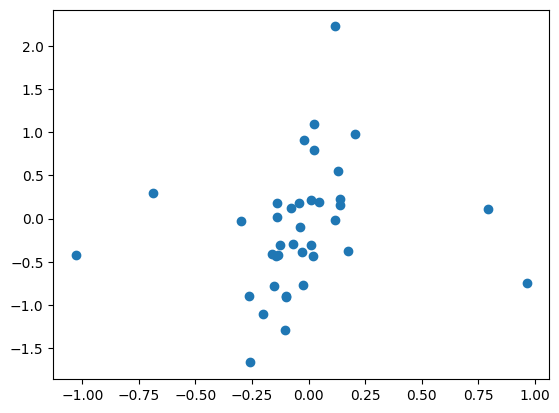

In [1767]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(dirs_pain_vs_rest_empirical[~np.isnan(dirs_pain_vs_rest_simulated)],
                           dirs_pain_vs_rest_simulated[~np.isnan(dirs_pain_vs_rest_simulated)],
                           func=lambda x, y: spearmanr(x, y).statistic,
                           method='approximate',
                           num_rounds=10000,
                           seed=42)

plt.scatter(dirs_pain_vs_rest_simulated,
        dirs_pain_vs_rest_empirical)

p_value, spearmanr(dirs_pain_vs_rest_empirical[~np.isnan(dirs_pain_vs_rest_simulated)],
                     dirs_pain_vs_rest_simulated[~np.isnan(dirs_pain_vs_rest_simulated)])

## Same but with low pain vs. high pain

In [473]:
rest = task[temperatures<43]
task = task[temperatures>=43]
sub_rest = sub_task[temperatures<43]
sub_task = sub_task[temperatures>=43]

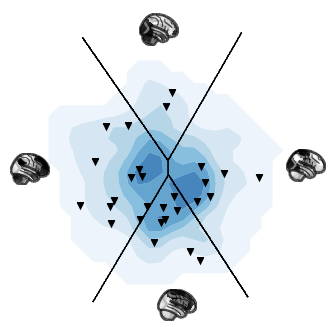

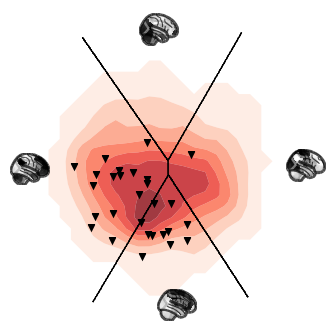

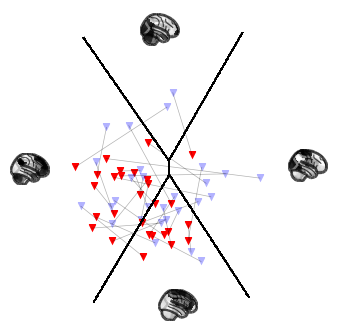

In [474]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='v', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_low.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Reds',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='v', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_high.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(ax=ax,
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )


for i in range(len(sub_means)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    hopfield_embeddings_all[noise].plot(sub_means_rest[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='v', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    hopfield_embeddings_all[noise].plot(sub_means_task[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='v', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_high-low.pdf')

In [475]:
sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

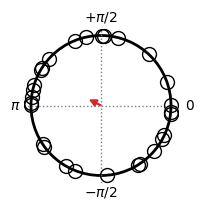

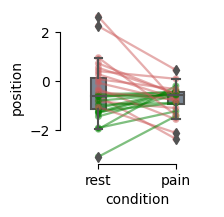

In [476]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_rest = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
emb_sub_means_task = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
diffs = emb_sub_means_task - emb_sub_means_rest
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

df = pd.DataFrame({
    'position': np.hstack((np.mean(emb_sub_means_rest, axis=1), np.mean(emb_sub_means_task, axis=1))),
    'subject': np.hstack((np.arange(1, len(phi)+1), np.arange(1, len(phi)+1))),
    'condition': np.hstack((np.repeat('rest', len(phi)), np.repeat('pain', len(phi))))
})

fig, ax = plt.subplots(figsize=(2, 2))

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'), ax=ax)
plt.savefig('../data_out/fig/pain_high-low_circplot.pdf')
plt.show()

df.condition = df.condition.astype("category")

fig, ax = plt.subplots(figsize=(2, 2))
plot_paired(data=df, dv='position', within='condition', subject='subject', order=['rest', 'pain'],
           pointplot_kwargs=dict(linewidth=2, alpha=0.5), ax=ax)
plt.savefig('../data_out/fig/pain_high-low_pairplot.pdf')

## Now we load the actual up-regulated data

In [1449]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD_run_07.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts_run_07.tsv', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-07_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    run_start = events.loc[0, 'onset']-18
    
    for i in events.index: 
        
        onset = int(np.round((events.loc[i, "onset"]-run_start)/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]
        #else:
        #    # anticipation and scoring
        #    current_block = ts[(onset+int(np.round((0)/_TR_))):(onset+int(np.round(6/_TR_))), :]
        #    rest = np.vstack((rest, current_block))                
   
# remove all nans (scrubbing)

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)
                                                              

perc. scrubbed: 0.5078534031413613
perc. scrubbed: 0.581151832460733
perc. scrubbed: 0.6596858638743456
perc. scrubbed: 0.806282722513089
perc. scrubbed: 0.6178010471204188
perc. scrubbed: 0.7068062827225131
perc. scrubbed: 0.6910994764397905
perc. scrubbed: 0.7120418848167539


((334, 122), (769, 122), array([42.3, 43.3, 44.3, 45.3, 46.3]), 334)

In [1450]:
# save for later:
rest_upreg = rest.copy()
task_upreg = task.copy()
sub_rest_upreg = sub_rest.copy()
sub_task_upreg = sub_task.copy()

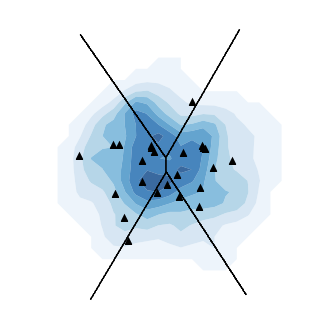

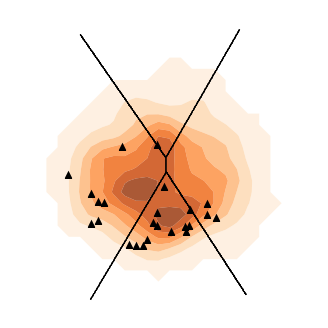

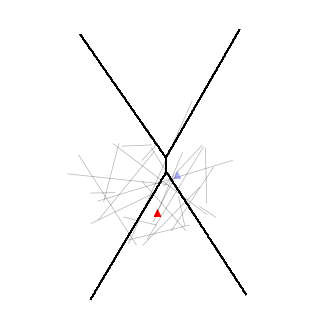

In [1451]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_rest_upreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Oranges',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_pain_upreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))


for i in range(len(sub_means_rest)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_rest[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='^', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_task[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='^', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_pain-rest_upreg.pdf')

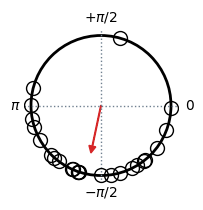

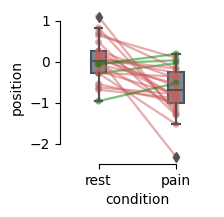

In [1452]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_rest = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
emb_sub_means_task = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
diffs = emb_sub_means_task - emb_sub_means_rest
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

df = pd.DataFrame({
    'position': np.hstack((np.mean(emb_sub_means_rest, axis=1), np.mean(emb_sub_means_task, axis=1))),
    'subject': np.hstack((np.arange(1, len(phi)+1), np.arange(1, len(phi)+1))),
    'condition': np.hstack((np.repeat('rest', len(phi)), np.repeat('pain', len(phi))))
})

fig, ax = plt.subplots(figsize=(2, 2))

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'), ax=ax)
plt.savefig('../data_out/fig/pain_upreg_circplot.pdf')
plt.show()

df.condition = df.condition.astype("category")

fig, ax = plt.subplots(figsize=(2, 2))
plot_paired(data=df, dv='position', within='condition', subject='subject', order=['rest', 'pain'],
           pointplot_kwargs=dict(linewidth=2, alpha=0.5), ax=ax)
plt.savefig('../data_out/fig/pain_upreg_pairplot.pdf')

## Load down-regulation data

In [1453]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD_run_03.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts_run_03.tsv', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-03_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    run_start = events.loc[0, 'onset']-18
    
    for i in events.index: 
        
        onset = int(np.round((events.loc[i, "onset"]-run_start)/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]
        #else:
        #    # anticipation and scoring
        #    current_block = ts[(onset+int(np.round((0)/_TR_))):(onset+int(np.round(6/_TR_))), :]
        #    rest = np.vstack((rest, current_block))                
   
# remove all nans (scrubbing)

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)
                                                              

perc. scrubbed: 0.6963350785340314
perc. scrubbed: 0.743455497382199
perc. scrubbed: 0.5916230366492147
perc. scrubbed: 0.6387434554973822
perc. scrubbed: 0.6701570680628273


((390, 122),
 (883, 122),
 array([40.8, 42.1, 42.3, 43.3, 43.4, 44.3, 44.7, 45.3, 46. , 46.3]),
 390)

In [1454]:
# save for later:
rest_downreg = rest.copy()
task_downreg = task.copy()
sub_rest_downreg = sub_rest.copy()
sub_task_downreg = sub_task.copy()

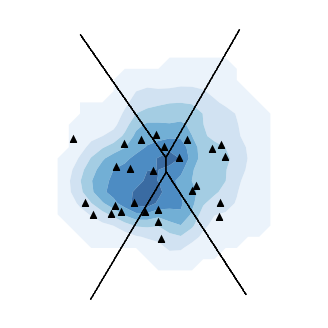

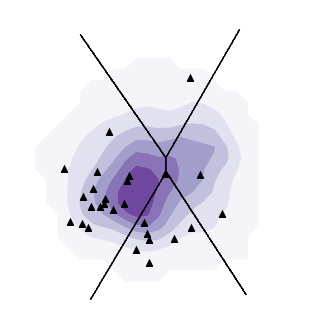

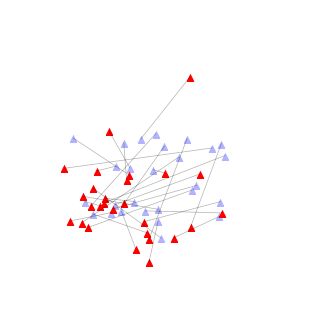

In [1456]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_rest_downreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Purples',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_pain_downreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))


for i in range(len(sub_means_rest)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_pain-rest_downreg.pdf')

## Up vs. Down

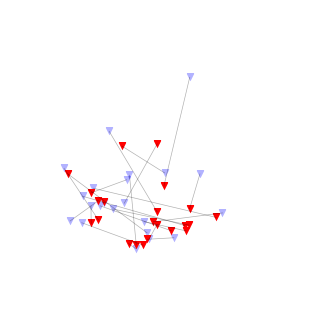

In [1458]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

sub_both = list(set(np.unique(sub_task_upreg)) & set(np.unique(sub_task_downreg)))

sub_means_upreg = np.array([np.mean(task_upreg[sub_task_upreg==sub], axis=0) for sub in sub_both])
sub_means_downreg = np.array([np.mean(task_downreg[sub_task_downreg==sub], axis=0) for sub in sub_both])


hopfield_embeddings_all[noise].plot(sub_means_downreg, plot_type='scatter', ax=ax,
                        marker='v', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_upreg, plot_type='scatter', ax=ax,
                        marker='v', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )

for i in range(len(sub_means_upreg)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_upreg[i], sub_means_downreg[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
plt.savefig("../data_out/fig/task_upreg-downreg_pairs.pdf")

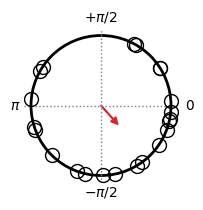

<Axes: xlabel='condition', ylabel='position'>

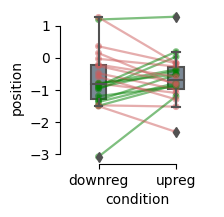

In [1459]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_upreg = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_upreg)[:, :2]
emb_sub_means_downreg = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_downreg)[:, :2]
diffs = emb_sub_means_upreg - emb_sub_means_downreg
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

# negate x 
emb_sub_means_upreg_negx = emb_sub_means_upreg.copy()
emb_sub_means_upreg_negx[0] *= -1
emb_sub_means_downreg_negx = emb_sub_means_downreg.copy()
emb_sub_means_downreg_negx[0] *= -1

df = pd.DataFrame({
    'position': np.hstack((np.mean(emb_sub_means_upreg_negx, axis=1), np.mean(emb_sub_means_downreg_negx, axis=1))),
    'subject': np.hstack((np.arange(1, len(phi)+1), np.arange(1, len(phi)+1))),
    'condition': np.hstack((np.repeat('upreg', len(phi)), np.repeat('downreg', len(phi))))
})

fig, ax = plt.subplots(figsize=(2, 2))

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'), ax=ax)
#plt.savefig('../data_out/fig/pain_upreg_circplot.pdf')
plt.show()

df.condition = df.condition.astype("category")

fig, ax = plt.subplots(figsize=(2, 2))
plot_paired(data=df, dv='position', within='condition', subject='subject', order=['downreg', 'upreg'],
           pointplot_kwargs=dict(linewidth=2, alpha=0.5), ax=ax)
#plt.savefig('../data_out/fig/pain_upreg_pairplot.pdf')

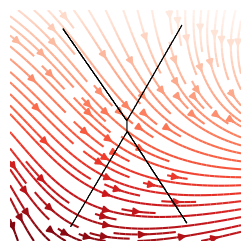

In [1760]:
noise=0.37
embedded_downreg = hopfield_embeddings_all[noise].embedding_model.transform(task_downreg)
embedded_upreg = hopfield_embeddings_all[noise].embedding_model.transform(task_upreg)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 3))

hopfield_embeddings_all[noise].plot(task_upreg, plot_type='contourf', ax=ax,
                    density_bins=10, density_sigma=0, levels=12, alpha=0, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_downreg, embedded_upreg, ax=ax, max_r=4,
                                  stream_bins = 3, density=1, linewidth=6, cmap='Reds')

dirs_up_vs_down_empirical = np.vstack((dir_x, dir_y))

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_up_vs_down.pdf')

0.0015515036540737727


100%|██████████| 10000/10000 [00:04<00:00, 2088.20it/s]


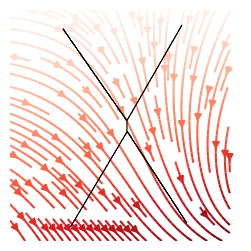

In [1761]:
#pain_map = network.State('../data_in/maps/placebo_metaanalysis_full_pain_g_random.nii.gz')

SNR = 0.08
signal = np.array(pain_map) * SNR
print(signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()])
signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()] += 1
simresults_downreg = analysis.simulate_activations(mtx.values, noise_coef=0.5, 
                                                      num_iter=10000, beta=0.04,
                                                      signal = signal,
                                                      random_state=42)

SNR = 0.08
signal = np.array(pain_map) * SNR
signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()] -= 1
simresults_upreg = analysis.simulate_activations(mtx.values, noise_coef=0.5, 
                                                      num_iter=10000, beta=0.04,
                                                      signal = signal,
                                                      random_state=43)

embedded_downreg = hopfield_embeddings_all[noise].embedding_model.transform(simresults_downreg.states)
embedded_upreg = hopfield_embeddings_all[noise].embedding_model.transform(simresults_upreg.states)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 3))

hopfield_embeddings_all[noise].plot(simresults_downreg.states, plot_type='contourf', ax=ax,
                    density_bins=20, density_sigma=0, levels=12, alpha=0, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_downreg, embedded_upreg, ax=ax, max_r=4,
                                  stream_bins = 3, density=1, linewidth=4, cmap='Reds')
dirs_up_vs_down_simulated = np.vstack((dir_x, dir_y))

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_up_vs_down_sim.pdf')

(0.033996600339966, 0.6904761904761906)

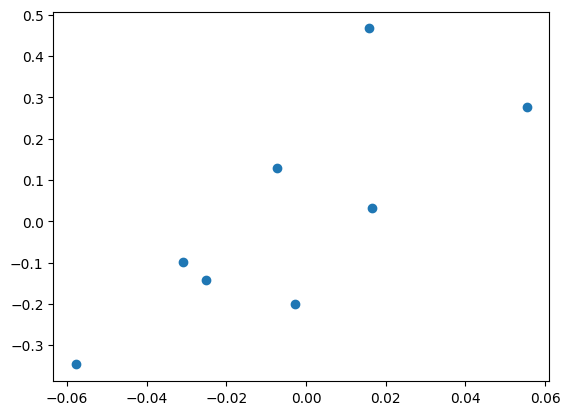

In [1769]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(dirs_up_vs_down_empirical[~np.isnan(dirs_up_vs_down_simulated)],
                           dirs_up_vs_down_simulated[~np.isnan(dirs_up_vs_down_simulated)],
                           func=lambda x, y: spearmanr(x, y).statistic,
                           method='approximate',
                           num_rounds=10000,
                           seed=42)

plt.scatter(dirs_up_vs_down_simulated,
        dirs_up_vs_down_empirical)

p_value, spearmanr(dirs_up_vs_down_empirical[~np.isnan(dirs_up_vs_down_simulated)],
                     dirs_up_vs_down_simulated[~np.isnan(dirs_up_vs_down_simulated)]).statistic


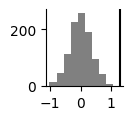

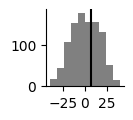

p(projection) = 0.0 p(energy) = 0.368


In [1478]:
from numpy.linalg import norm
random = np.random.default_rng(42)
noise = 0.37
num_perm = 1000

sub_both = list(set(np.unique(sub_task_upreg)) & set(np.unique(sub_task_downreg)))

sub_means_upreg = np.array([np.mean(task_upreg[sub_task_upreg==sub], axis=0) for sub in sub_both])
sub_means_downreg = np.array([np.mean(task_downreg[sub_task_downreg==sub], axis=0) for sub in sub_both])

upreg_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_upreg)[:, :2]
downreg_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_downreg)[:, :2]
diffs = upreg_embedded - downreg_embedded
true_diffs_norm = np.array([norm(d) for d in diffs])
true_diff_mean = np.mean(diffs_norm)

energy_downreg = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_downreg])
energy_upreg = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_upreg])
true_energy_diff = energy_upreg - energy_downreg
true_energy_diff_mean = np.mean(true_energy_diff)

n = len(diffs)
diffs = []
energy_diffs = []

for p in range(num_perm):
    
    
    # swap conditions randomly (i.e. sign flip)
    
    perm_i = random.choice([1,-1], n)
    diffs.append(np.mean(true_diffs_norm * perm_i))
    energy_diffs.append(np.mean(true_energy_diff * perm_i))
                                                  

plt.figure(figsize=(1,1))
plt.hist(diffs, color='gray')
plt.axvline(true_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_upreg_vs_downreg.pdf')
plt.show()

plt.figure(figsize=(1,1))
plt.hist(energy_diffs, color='gray')
plt.axvline(true_energy_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_upreg_vs_downreg_energy.pdf')
plt.show()


print('p(projection) =', (diffs>true_diff_mean).sum()/num_perm,
      'p(energy) =', (energy_diffs>true_energy_diff_mean).sum()/num_perm)
    

## Hopfield embeddings vs. various activation maps

../data_in/maps/visual_association-test_z_FDR_0.01.nii.gz
../data_in/maps/reward_association-test_z_FDR_0.01.nii.gz
../data_in/maps/semantic memory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/sentences_association-test_z_FDR_0.01.nii.gz
../data_in/maps/auditory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/sensory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/language_association-test_z_FDR_0.01.nii.gz
../data_in/maps/motor_association-test_z_FDR_0.01.nii.gz
../data_in/maps/autobiographical_association-test_z_FDR_0.01.nii.gz
../data_in/maps/theory mind_association-test_z_FDR_0.01.nii.gz
../data_in/maps/self referential_association-test_z_FDR_0.01.nii.gz
../data_in/maps/pain_association-test_z_FDR_0.01.nii.gz
../data_in/maps/default mode_association-test_z_FDR_0.01.nii.gz
../data_in/maps/decision_association-test_z_FDR_0.01.nii.gz
../data_in/maps/working memory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/face_association-test_z_FDR_0.01.nii.gz


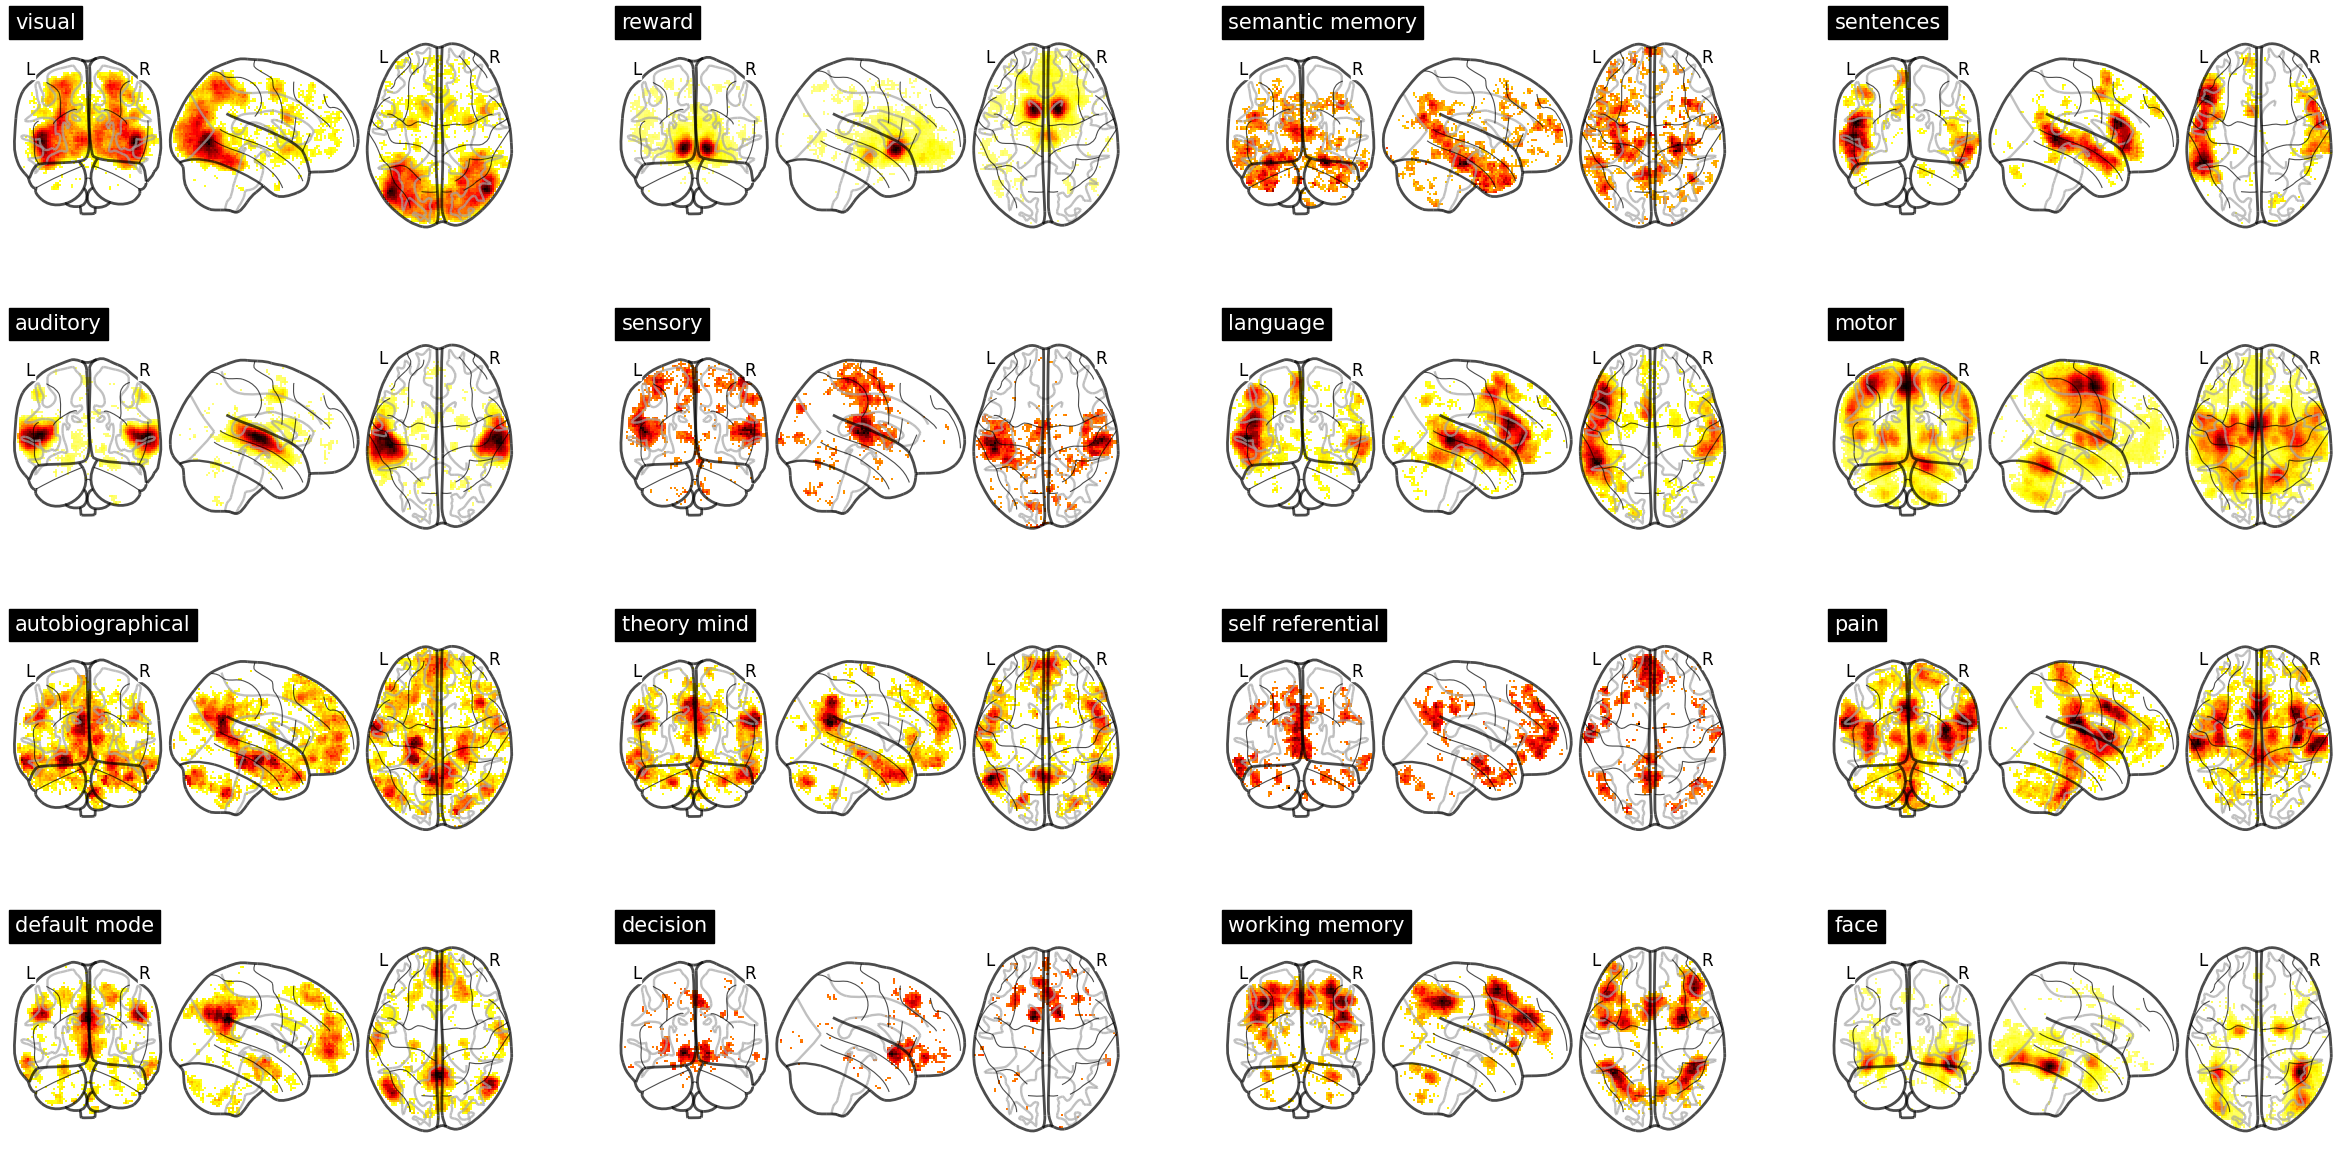

In [186]:
# load in Neurosynth maps

fig, axes = plt.subplots(4, 4, figsize=(30, 15))

maps = []
for i, f in enumerate(glob('../data_in/maps/*association-test*')):
    print(f)
    maps.append(network.State(f))
    plotting.plot_glass_brain(f, figure = fig, axes = axes.flat[i], title = f.split('/')[-1].split('_association-test')[0])
plt.show()

In [457]:
# load some resting state data
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


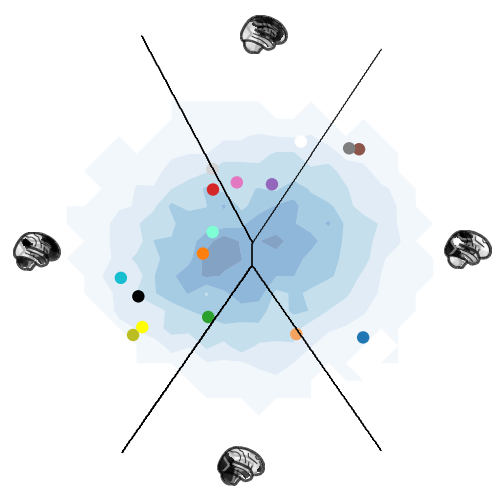

In [459]:
import matplotlib.colors as mcolors
npoise= 0.37

ax = hopfield_embeddings_all[noise].plot(np.array(all_ts), plot_type='contourf',
                             density_bins=30, density_sigma=0, levels=6, alpha=0.8, cmap='Blues',
                        attractor_plot_type='scatter',
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

colseries = list(mcolors.TABLEAU_COLORS.values()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
colors = np.array(colseries[:len(maps)])

ax = hopfield_embeddings_all[noise].plot(np.tanh(np.array(maps)), alpha=1, s=80, c=colors, plot_type='scatter',
                        ax=ax.figure.add_axes(ax.get_position(), polar=True, frameon=False),
                        attractor_plot_type='glassbrain',
                        attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
#ax.set_axisbelow(True)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/neurosynth.pdf')

In [194]:
tmp = list(mcolors.TABLEAU_COLORS.keys()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
{f : tmp[i] for i, f in enumerate(glob('../data_in/maps/*association-test*'))}

{'../data_in/maps/visual_association-test_z_FDR_0.01.nii.gz': 'tab:blue',
 '../data_in/maps/reward_association-test_z_FDR_0.01.nii.gz': 'tab:orange',
 '../data_in/maps/semantic memory_association-test_z_FDR_0.01.nii.gz': 'tab:green',
 '../data_in/maps/sentences_association-test_z_FDR_0.01.nii.gz': 'tab:red',
 '../data_in/maps/auditory_association-test_z_FDR_0.01.nii.gz': 'tab:purple',
 '../data_in/maps/sensory_association-test_z_FDR_0.01.nii.gz': 'tab:brown',
 '../data_in/maps/language_association-test_z_FDR_0.01.nii.gz': 'tab:pink',
 '../data_in/maps/motor_association-test_z_FDR_0.01.nii.gz': 'tab:gray',
 '../data_in/maps/autobiographical_association-test_z_FDR_0.01.nii.gz': 'tab:olive',
 '../data_in/maps/theory mind_association-test_z_FDR_0.01.nii.gz': 'tab:cyan',
 '../data_in/maps/self referential_association-test_z_FDR_0.01.nii.gz': 'black',
 '../data_in/maps/pain_association-test_z_FDR_0.01.nii.gz': 'white',
 '../data_in/maps/default mode_association-test_z_FDR_0.01.nii.gz': 'yell

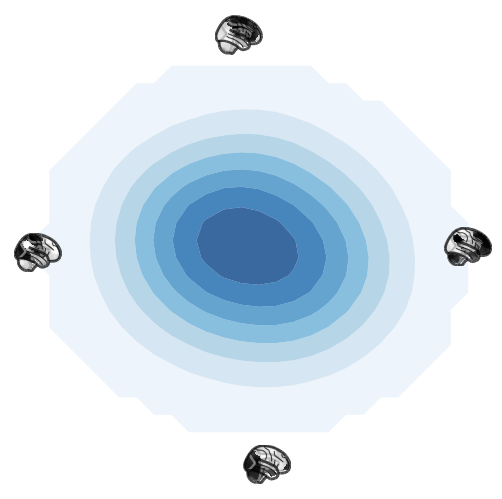

In [1775]:
ax = hopfield_embeddings_all[noise].plot(np.array(all_ts), plot_type='contourf',
                             density_bins=30, density_sigma=2, levels=6, alpha=0.8, cmap='Blues',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary_r'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/schematics.pdf')